In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import deepdish as dd
import scipy.stats as stats

from grid_criticality import analysis_path, path_pr, get_distances
from sweep import get_script
from grid_postprocessing import p_list, r_list

import plot_utils as pu

In [2]:
data=pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0).rename(columns={'delta_p': 'delta_p_mean'})

In [3]:
def get_kslices(data, step=10):
    slices = []
    for lo in range(0, 95, int(step/2)):
        masked = data[(data['k_inh_init'] > lo) * (data['k_inh_init'] <= lo + step)].copy().reset_index(drop=True)
        masked['k_slice'] = lo
        masked['k_slice_size'] = step
        slices.append(masked)
    return slices

In [4]:
def correlate_slices(slices, xvar, yvar, xlabel=None, ylabel=None, axs=None, info='title'):
    slopes = []
    if axs is None:
        axs = [None]*len(slices)
    if xlabel is None:
        xlabel = str(xvar)
    if ylabel is None:
        ylabel = str(yvar)
    for ax, slice in zip(axs, slices):
        if len(slice) == 0:
            continue
        x = (slice[xvar] if type(xvar) is str else xvar(slice)).to_numpy()
        y = (slice[yvar] if type(yvar) is str else yvar(slice)).to_numpy()
        k, step = slice.loc[0, 'k_slice':'k_slice_size'].astype(int)

        reg = stats.linregress(x, y)
        slopes.append({'k_slice': k, 'k_slice_size': step, 'slope': reg.slope, 'pval': reg.pvalue})
        
        if ax is not None:
            xtremes = np.asarray([x.min(), x.max()])
            title = f'{k} < $k_{{inh}}$ <= {k+step}'
            infostr = f'$r={reg.rvalue:.2g}, p={reg.pvalue:.1g}$'
            ax.plot(xtremes, xtremes*reg.slope + reg.intercept,
                    label=infostr if info=='legend' else None,
                    lw=2 if reg.pvalue<.05 else 1, c='C1', zorder=5)

            ax.plot(x, y, '.', ms=3, zorder=6)

            if info == 'legend':
                ax.legend()
            elif info == 'title':
                title = f'{title}\n{infostr}'
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

    df = pd.DataFrame(slopes)
    df['significant'] = df['pval']<0.05/len(slices)
    df['positive'] = df['slope'] >= 0
    return df

In [5]:
slices = get_kslices(data)

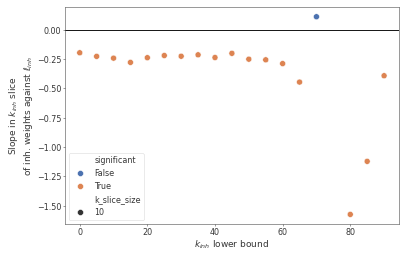

In [6]:
def plot_correlations(ax, slopes, xlabel, ylabel, marker='o'):
    ax.axhline(0, color='k', lw=1, zorder=1)
    sns.scatterplot(ax=ax, data=slopes, x='k_slice', y='slope', zorder=2, hue='significant', style='k_slice_size', markers=[marker])
    ax.set_xlabel('$k_{inh}$ lower bound')
    ax.set_ylabel(f'Slope in $k_{{inh}}$ slice\nof {ylabel} against {xlabel}')

fig, ax = plt.subplots()
slopes = correlate_slices(slices, xvar='r_inh_mean_init', yvar='Ix_mean')
plot_correlations(ax, slopes, xlabel='$\ell_{inh}$', ylabel='inh. weights')

In [7]:
delta_p = pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0)
ioi = 976
poi = delta_p.loc[ioi, 'p_inh']
roi = delta_p.loc[ioi, 'r_inh']
runseed = delta_p.loc[ioi, 'runseed']
net = delta_p.loc[ioi, 'net']

In [8]:
script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{path_pr(poi)}_rinh_{path_pr(roi)}_runseed_{runseed}')
p_inh=script.params['p_connection']['IE']
r_inh=script.params['radius_inh']

distances = get_distances(script, path)

W_stats = dd.io.load(f'{path}/W_stats2.h5')
W_matrix = W_stats['matrix']

N, N_nets = script.params['N'], script.params['N_nets']
inh_ratio = script.params.get('inhibitory_ratio', 0.2)
N_exc = int(N*(1-inh_ratio))
N_inh = N - N_exc

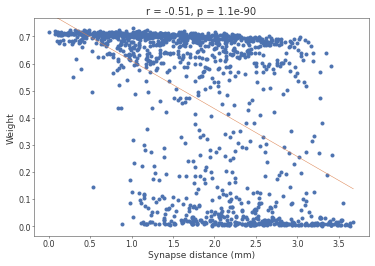

In [9]:
def plot_weight_vs_distance(ax):
    lsyn = np.asarray([distances[net][pre,post] for pre in range(N_exc,N) for post in range(N)])
    Wsyn = np.asarray([np.mean([w[pre,post] for w in W_matrix[net]]) for pre in range(N_exc,N) for post in range(N)])
    lsyn = lsyn[~np.isnan(Wsyn)]
    Wsyn = Wsyn[~np.isnan(Wsyn)]
    ax.plot(lsyn, Wsyn, '.')
    ax.set_xlabel('Synapse distance (mm)')
    ax.set_ylabel('Weight')
    ylim = ax.get_ylim()

    reg = stats.linregress(lsyn, Wsyn)
    x = np.asarray([min(lsyn), max(lsyn)])
    ax.plot(x, reg.intercept + x*reg.slope)
    ax.set_ylim(ylim)
    ax.set_title(f'r = {reg.rvalue:.2g}, p = {reg.pvalue:.2g}')

fig, ax = plt.subplots()
plot_weight_vs_distance(ax)

In [10]:
correlations = pd.read_csv(f'{analysis_path}/length_weight_correlations.csv')

In [11]:
correlations.rvalue.mean(), correlations.rvalue.std()

(-0.32051470879504357, 0.18278903310781808)

In [12]:
mask = correlations.r_inh >= 2
correlations[mask].rvalue.mean(), correlations[mask].rvalue.std()

(-0.42782961592325075, 0.09944827442089348)

array([[<Axes: ylabel='1.0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.7'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='0.5', ylabel='0.1'>, <Axes: xlabel='1.0'>,
        <Axes: xlabel='2.0'>, <Axes: xlabel='3.0'>, <Axes: xlabel='4.0'>]],
      dtype=object)

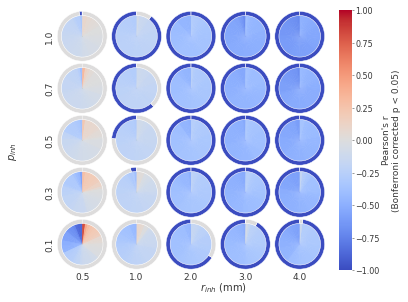

In [13]:
fig = plt.figure(layout='compressed', facecolor='w')

def plot_pies(fig):
    axs = fig.subplots(5,5)
    colormap = plt.get_cmap('coolwarm')

    for p, row in zip(p_list, axs):
        for r, ax in zip(r_list, row):
            data = correlations[(correlations.p_inh==p) & (correlations.r_inh==r)].sort_values(by='rvalue')
            
            # Number of slices
            num_slices = len(data)
            
            # Assign colors to slices based on normalized r values, sorting by r and excluding Bonferroni-corrected p<.05 to the center
            c = lambda r: colormap(min(1., max(0., (r+1)/2)))
            pos = [c(r) for r,p in zip(data.rvalue, data.pvalue) if r > 0 and p*len(data) < .05]
            insig = [c(r) for r,p in zip(data.rvalue, data.pvalue) if p *len(data)>= .05]
            # insig = ['w' for p in data.pvalue if p *len(data)>= .05]
            neg = [c(r) for r,p in zip(data.rvalue, data.pvalue) if r < 0 and p*len(data) < .05]
            colors = neg + insig + pos
            
            # Plot the pie chart with equal-sized slices
            for angle in (88, 90):  # Rotated double underneath to avoid edge artifacts in pdf export
                ax.pie(np.ones(num_slices), startangle=angle, colors=colors, wedgeprops=dict(lw=0))

            # Draw a larger pie underneath with three slices and categorical colors
            category_sizes = [len(neg), len(insig), len(pos)]
            category_colors = [colormap(i) for i in np.linspace(0,1,3)]
            ax.pie(category_sizes, radius=1.2, startangle=90, colors=category_colors, wedgeprops=dict(width=0.2, edgecolor='w'))

    # Set labels and show the plot
    for ax, p_inh in zip(axs[:, 0], p_list):
        ax.set_ylabel(p_inh)
    for ax, r_inh in zip(axs[-1, :], r_list):
        ax.set_xlabel(r_inh)
    fig.supxlabel('$r_{inh}$ (mm)', fontsize=plt.rcParams['axes.titlesize'])
    fig.supylabel('$p_{inh}$', fontsize=plt.rcParams['axes.titlesize'])

    # Add a colorbar to the right of the plot
    norm = plt.Normalize(vmin=-1, vmax=1)
    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axs)
    cb.set_label('Pearson\'s r\n(Bonferroni corrected p < 0.05)')
    cb.outline.set_color('none')

    fig.get_layout_engine().set(h_pad=0, hspace=0, w_pad=0, wspace=0)
    
    return axs

plot_pies(fig)

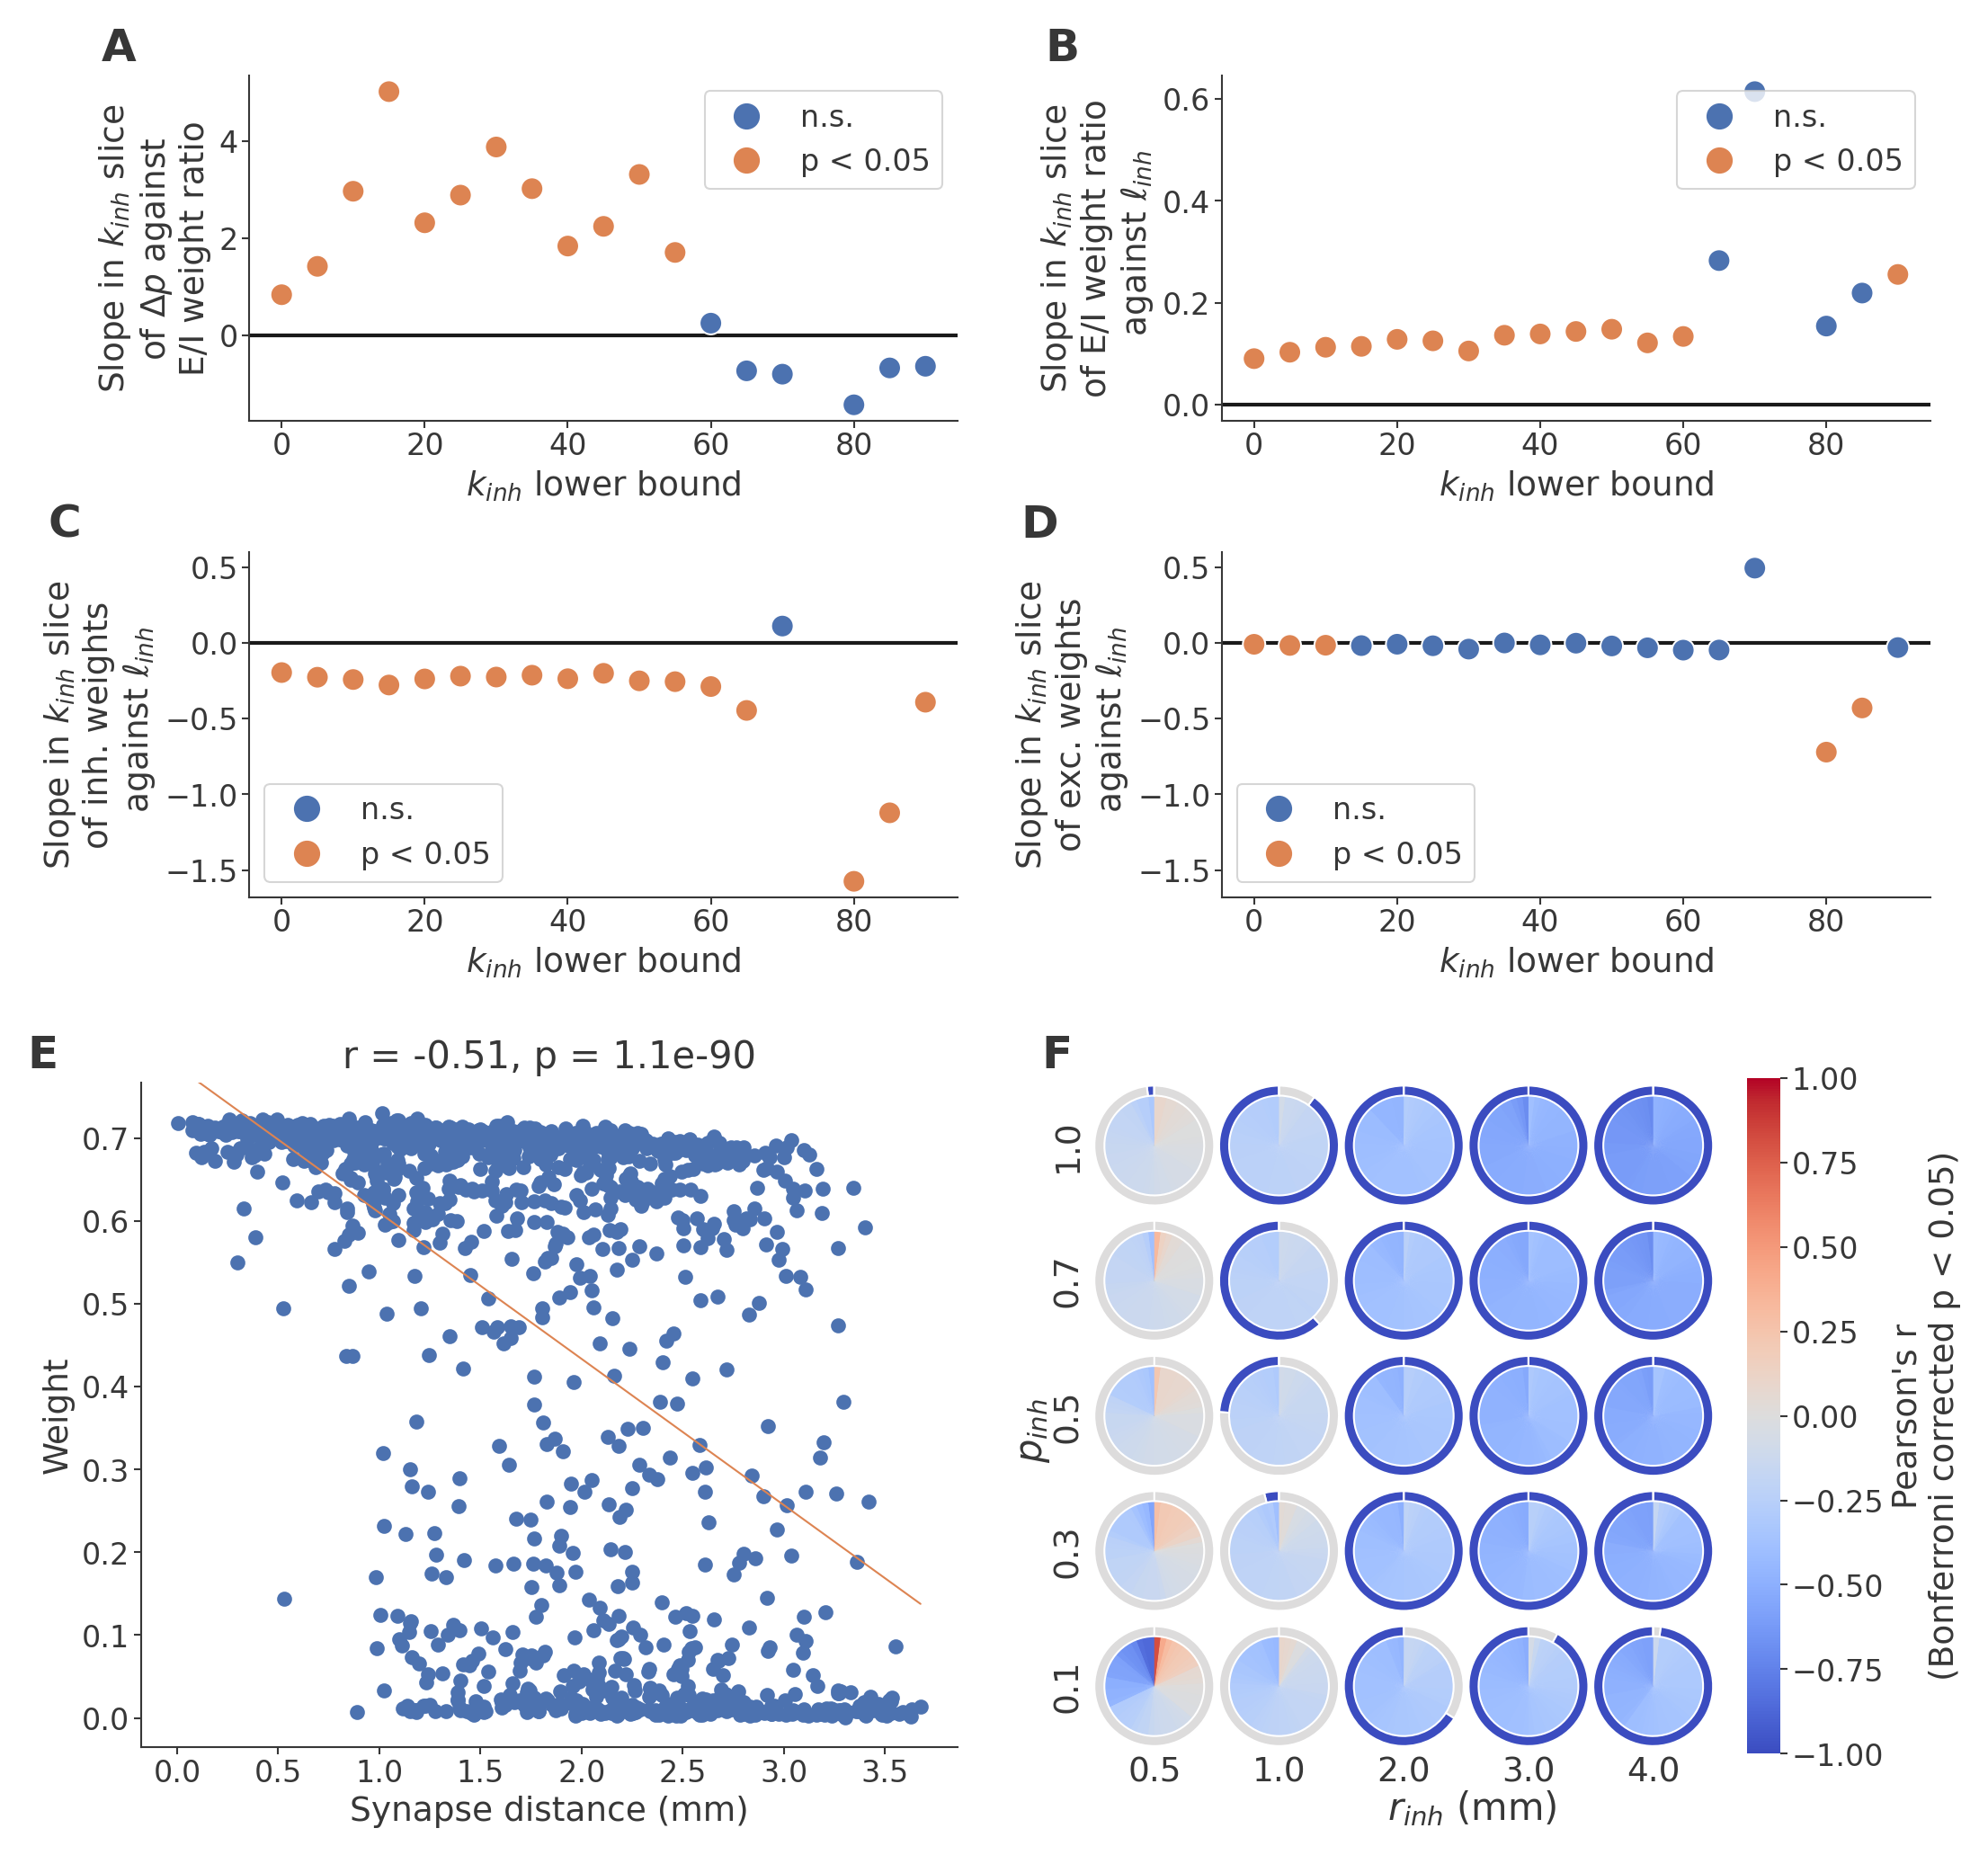

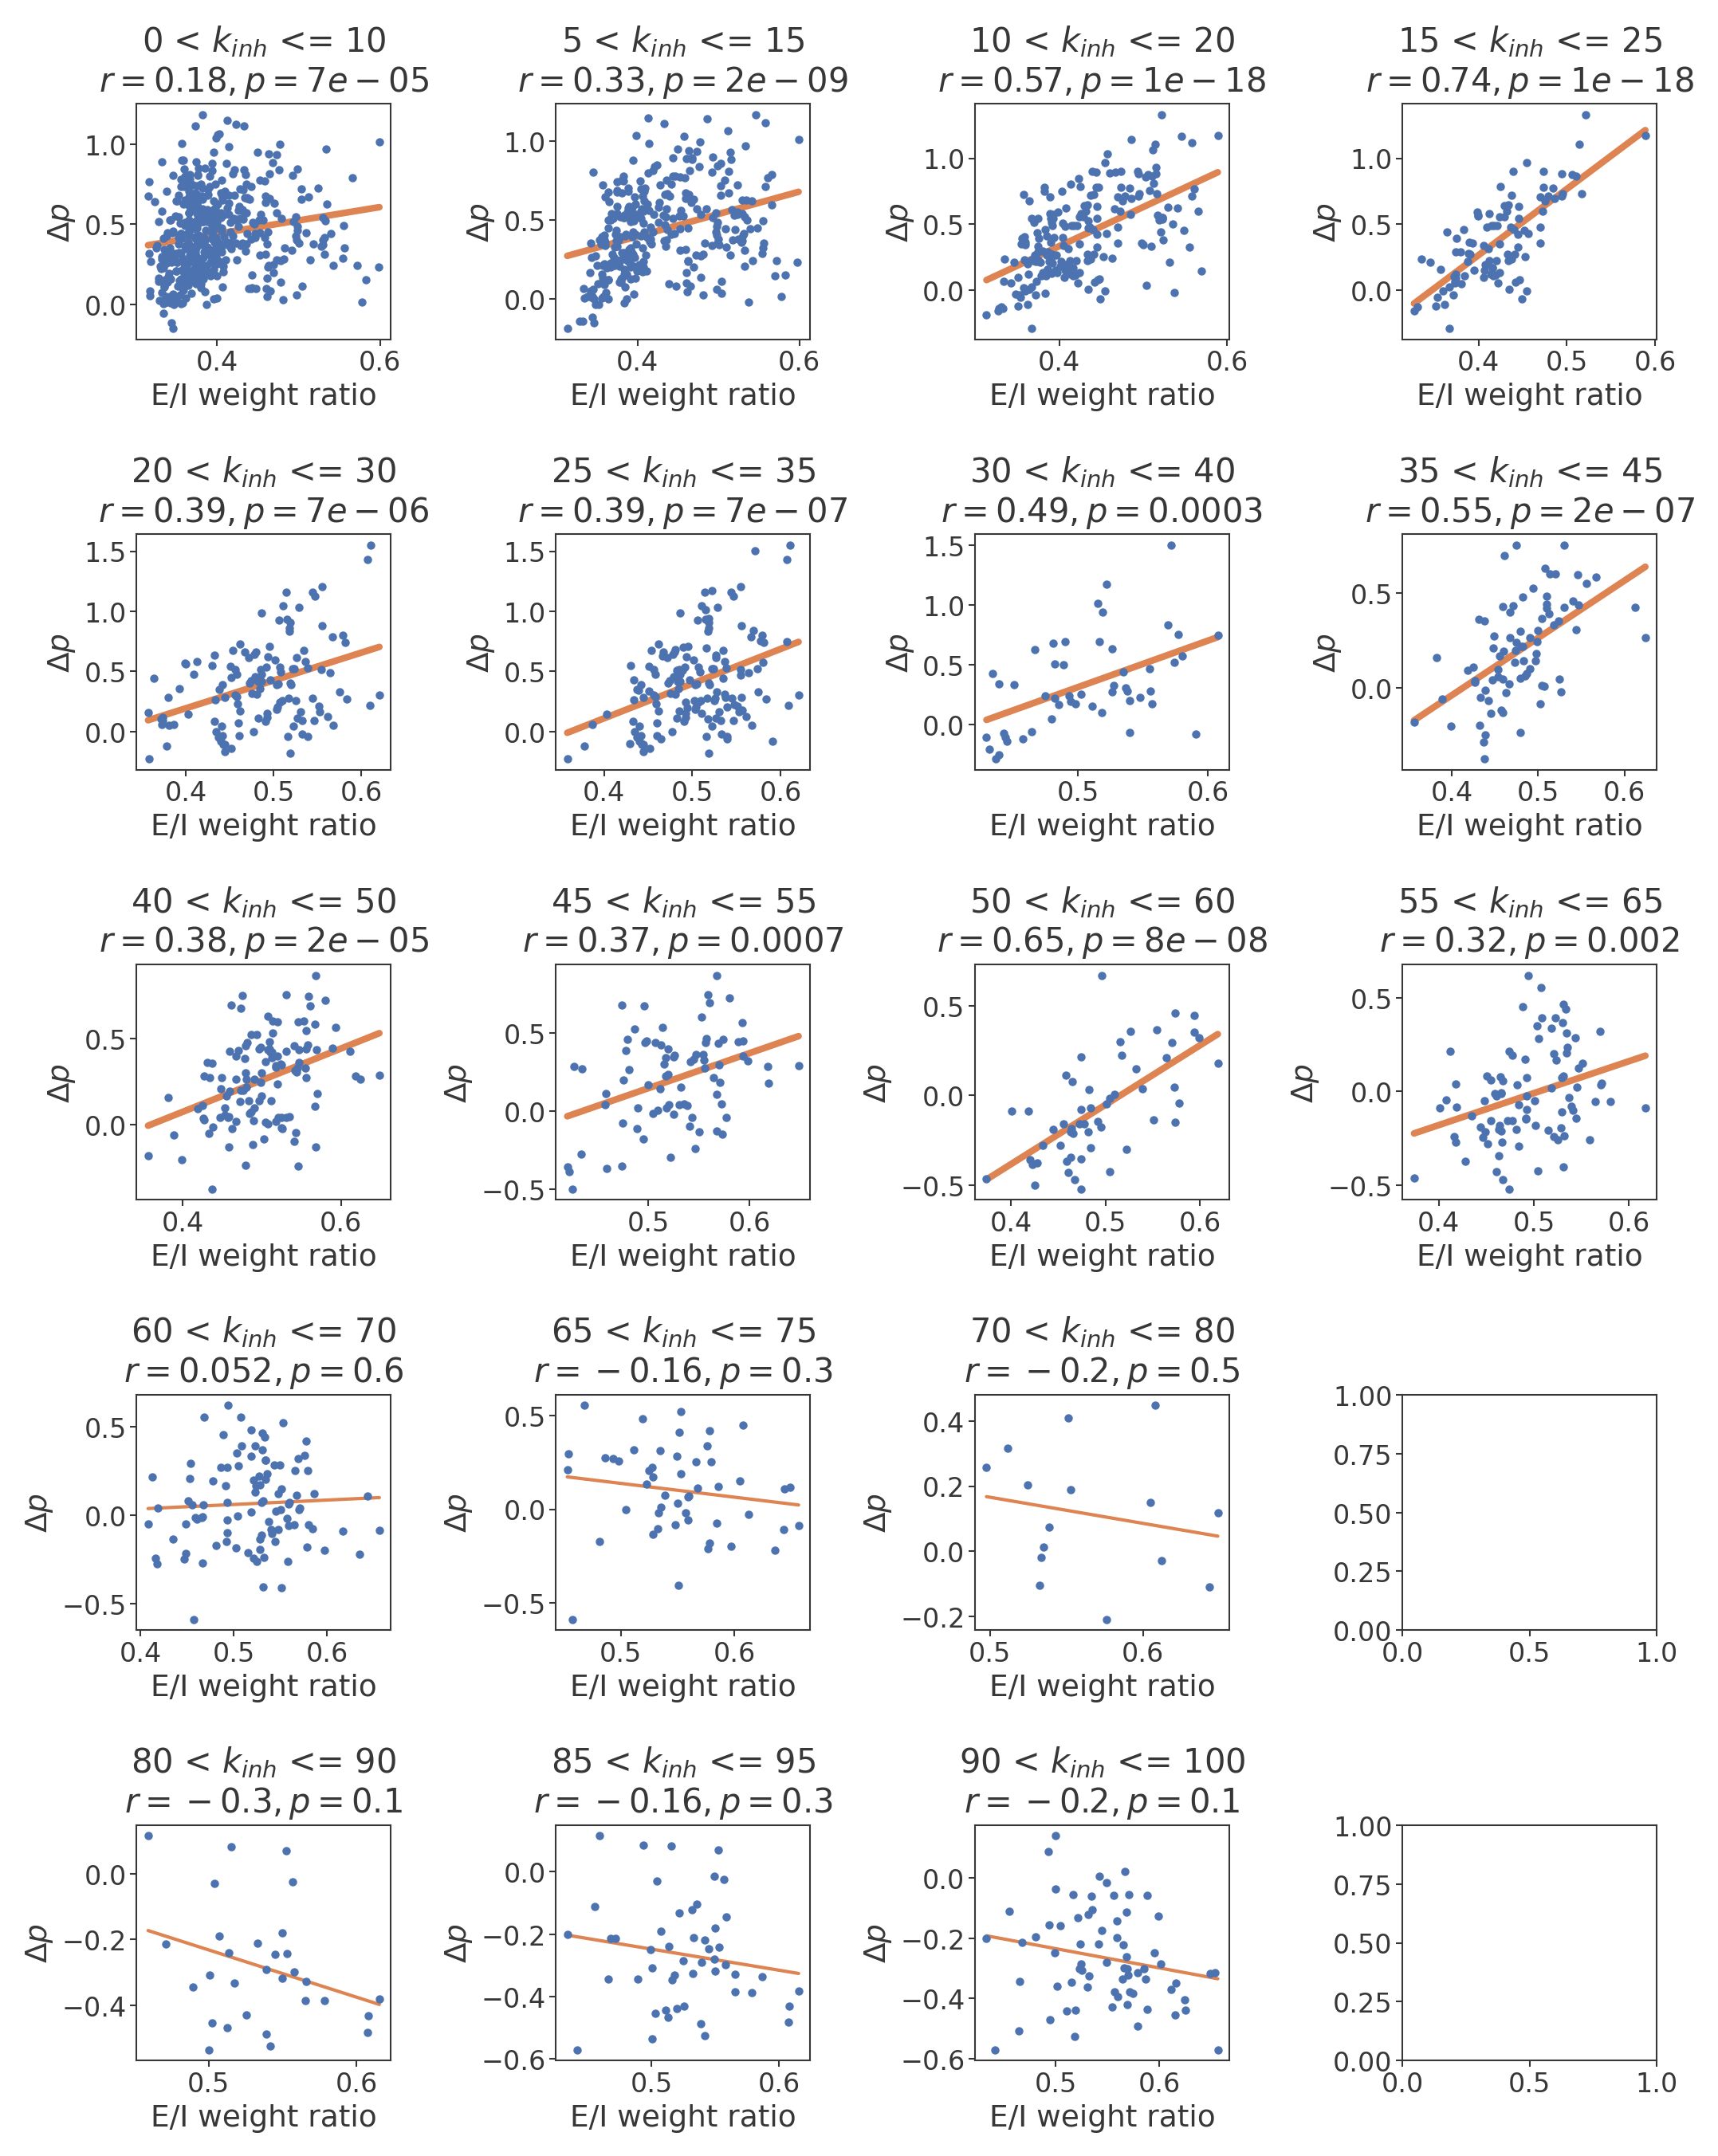

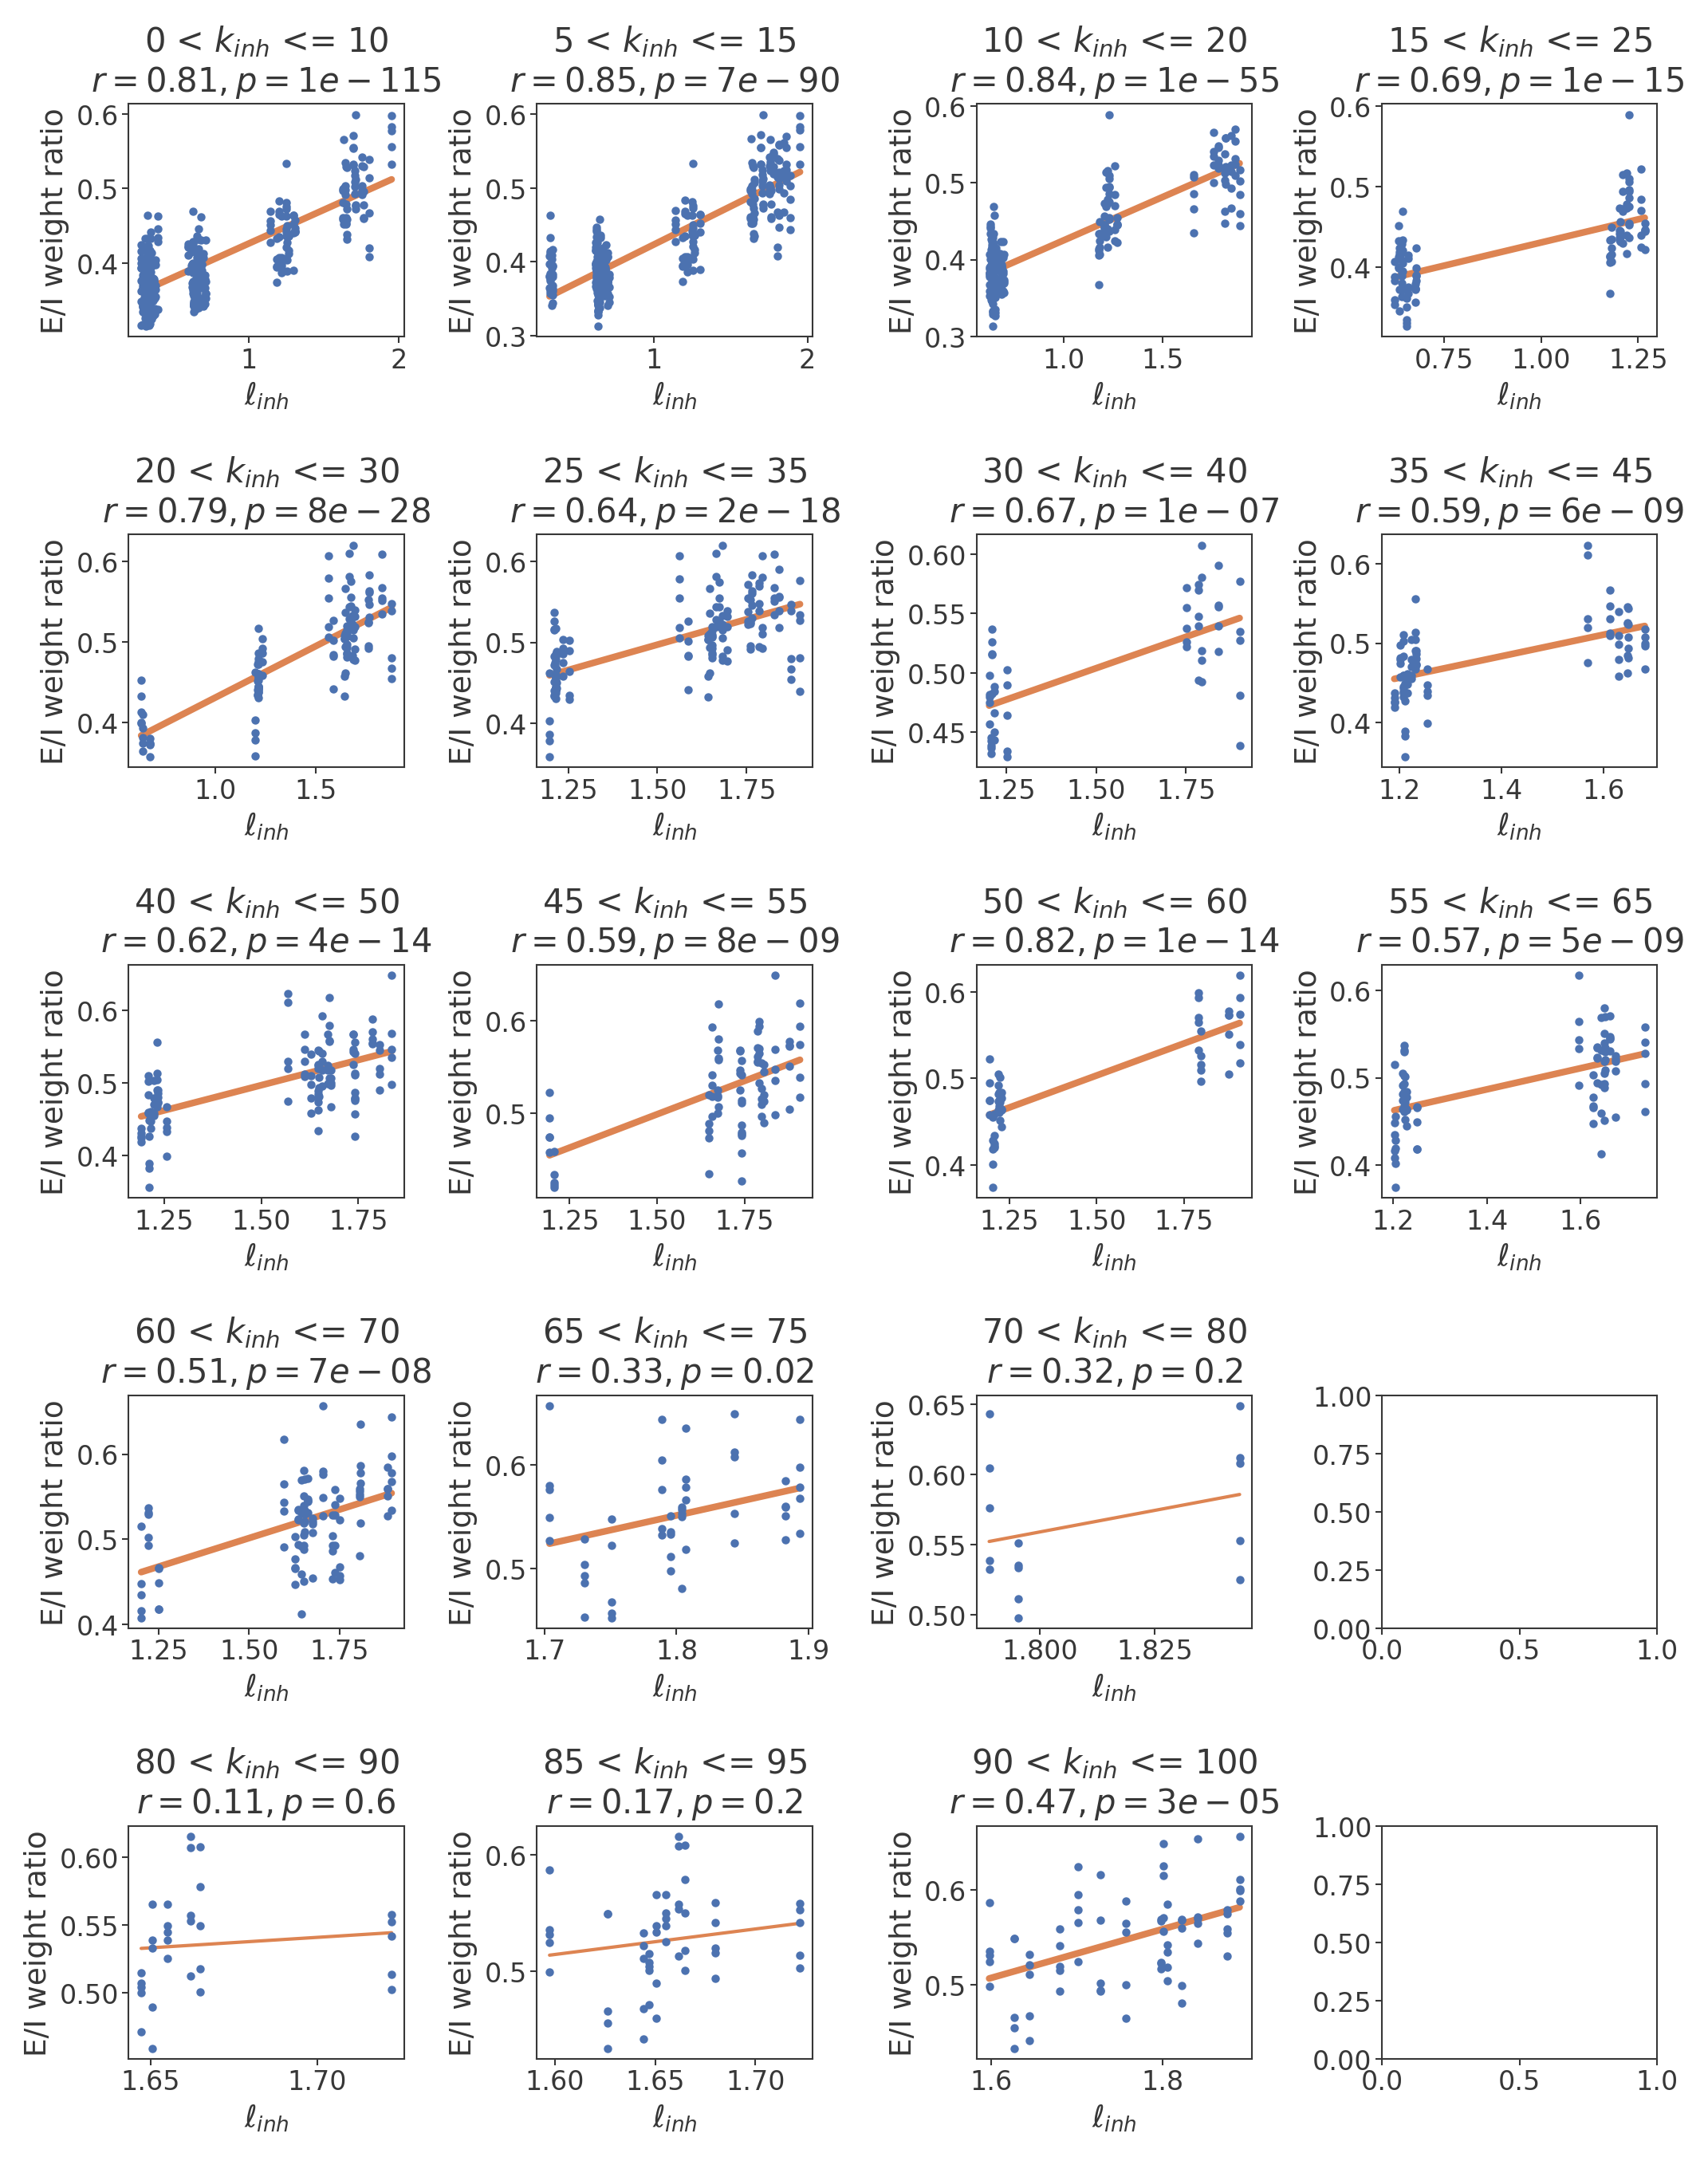

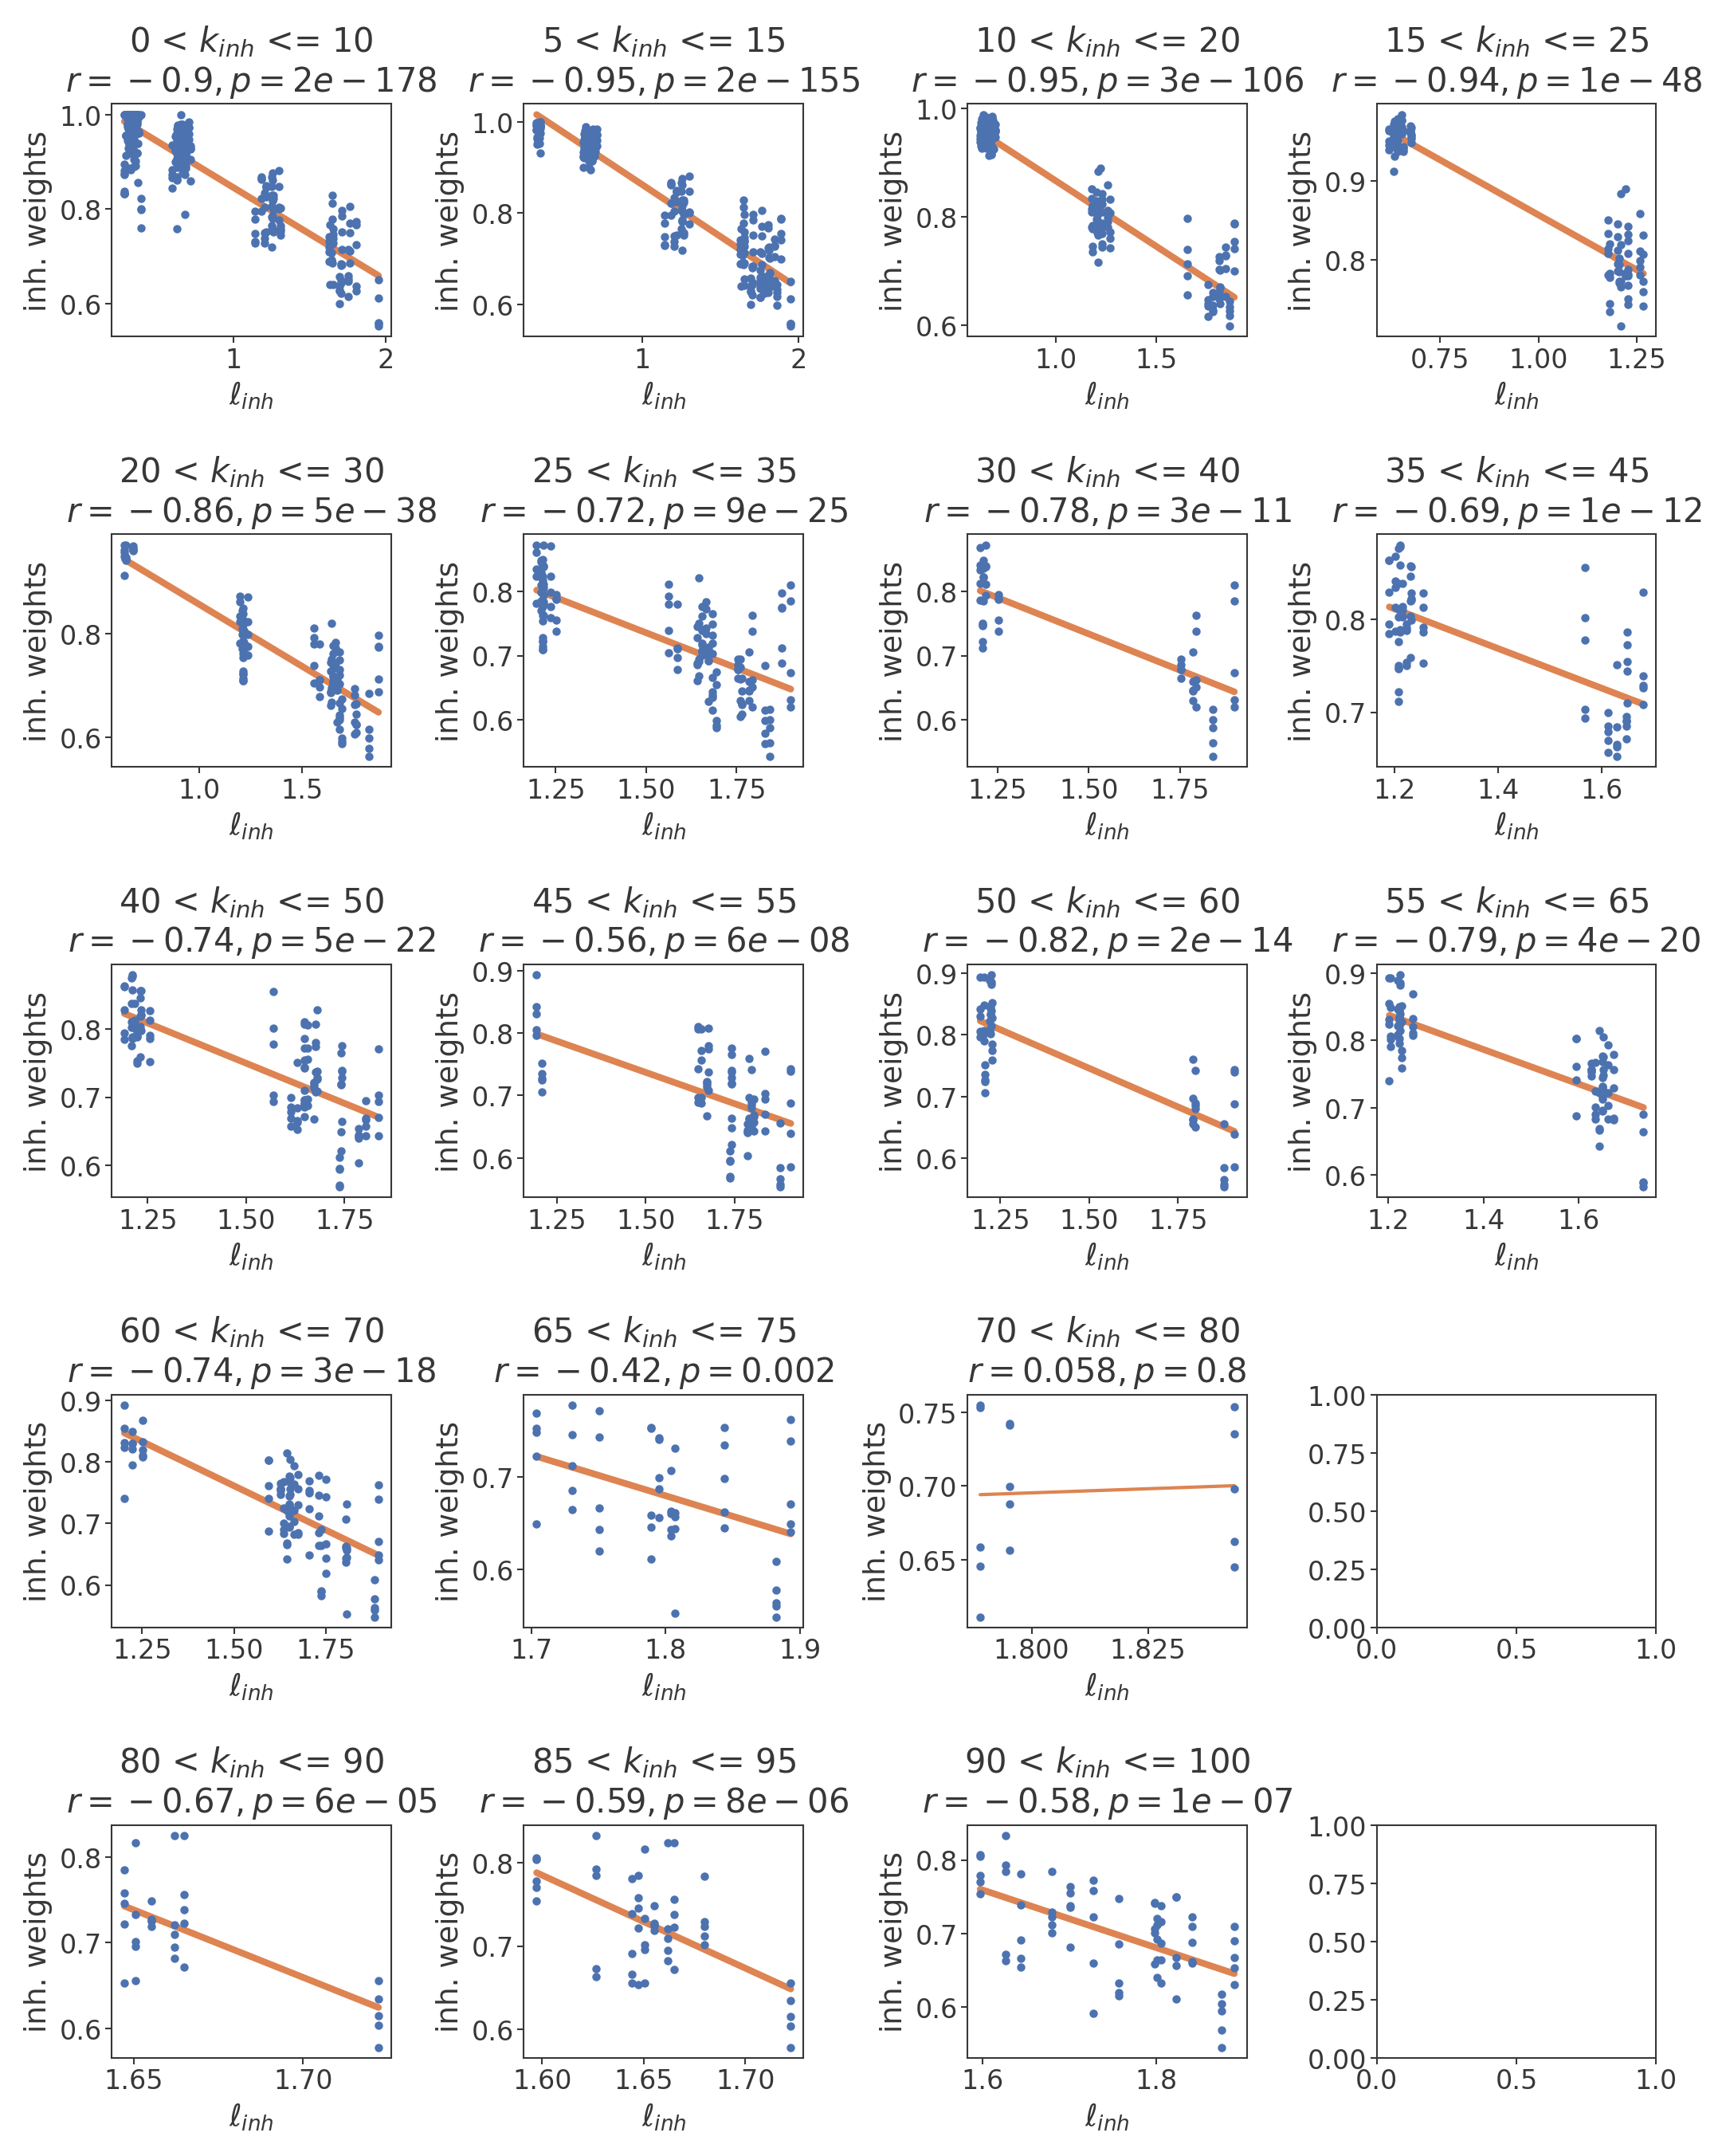

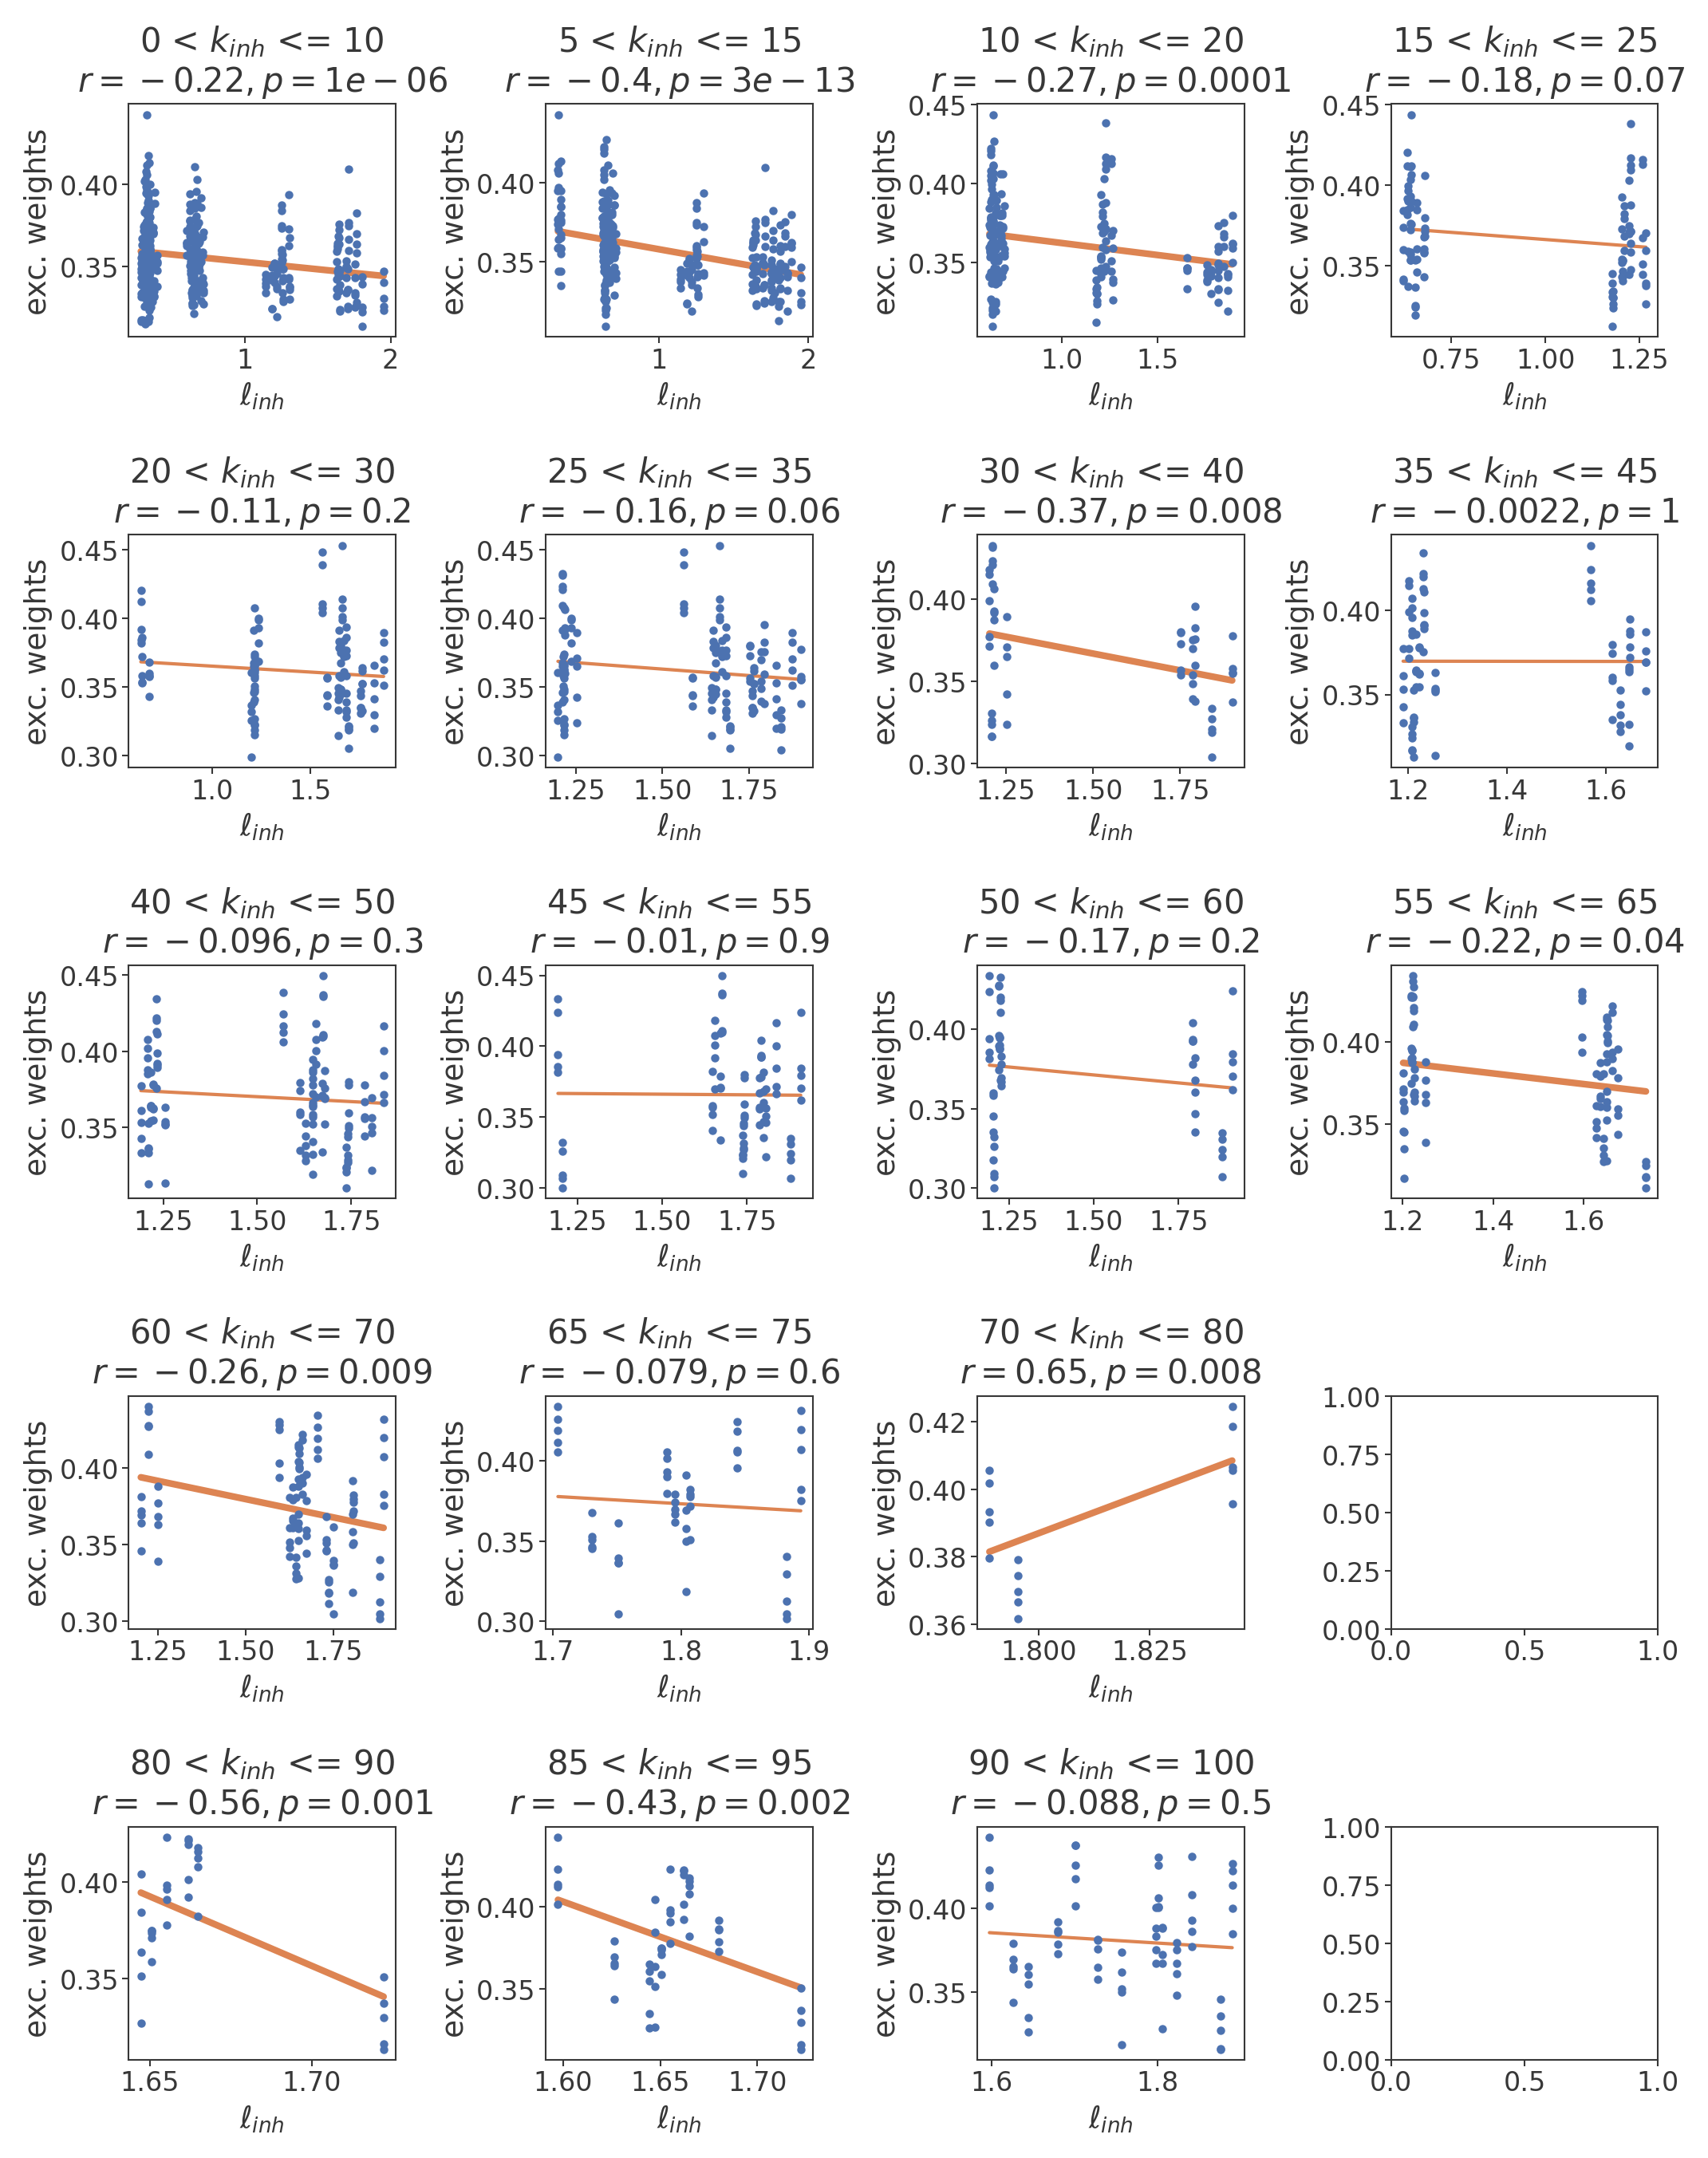

In [14]:
fig = plt.figure(figsize=pu.fullwidth(6), layout='compressed', facecolor='w', dpi=300)
subfigs = fig.subfigures(2, 2, height_ratios=(1.2,1), hspace=.06, wspace=.06)

def simple_legend(ax, **kwargs):
    nonsig = ax.plot([], 'oC0', lw=3)
    sig = ax.plot([], 'oC1', lw=3)
    ax.legend(nonsig + sig, ['n.s.', 'p < 0.05'], **kwargs)

axs = np.asarray([subfigs[0,0].subplots(2), subfigs[0,1].subplots(2)]).T

for i, (ax, xvar, xlabel, yvar, ylabel) in enumerate(((axs[0,0],
                                                        lambda slice: slice['Ex_mean']/slice['Ix_mean'], '\nE/I weight ratio',
                                                        'delta_p_mean', '$\Delta p$'),
                                                      (axs[0,1],
                                                        'r_inh_mean_init', '$\ell_{inh}$',
                                                        lambda slice: slice['Ex_mean']/slice['Ix_mean'], 'E/I weight ratio\n'),
                                                      (axs[1,0],
                                                        'r_inh_mean_init', '$\ell_{inh}$',
                                                        'Ix_mean', 'inh. weights\n'),
                                                      (axs[1,1],
                                                        'r_inh_mean_init', '$\ell_{inh}$',
                                                        'Ex_mean', 'exc. weights\n'))):
    sfig, sax = plt.subplots(5, 4, figsize=pu.fullwidth(8), layout='compressed', facecolor='w', dpi=300, gridspec_kw=dict(hspace=.1, wspace=.1))
    slopes = correlate_slices(slices, xvar=xvar, yvar=yvar, xlabel=xlabel.strip(), ylabel=ylabel.strip(), axs=sax.flatten())
    sfig.savefig(f'Figure 7.Suppl{i}.tif', bbox_inches='tight')
    
    plot_correlations(ax, slopes, xlabel=xlabel, ylabel=ylabel)

    sns.despine(ax=ax)
    pu.label_panel(ax, i)
    simple_legend(ax, loc='upper right' if i<2 else 'lower left')

axs[1,1].sharey(axs[1,0])

ax = subfigs[1,0].subplots()
plot_weight_vs_distance(ax)
sns.despine(ax=ax)
pu.label_panel(ax, 4)

axs = plot_pies(subfigs[1,1])
pu.label_panel(axs[0,0], 5)

fig.savefig('Figure 7.tif', bbox_inches='tight')